In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mmcv
from mmengine.utils import track_iter_progress
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
import json 
from pathlib import Path
import numpy as np
# Show the results
from mmcv.transforms import LoadImageFromFile, Compose, Resize
import cv2
import numpy as np
import shutil

In [ ]:
# read all the images from the folder and subfolders in the path:
def read_images(path):
    images = []
    for img_path in Path(path).rglob("*.tif"):
        images.append(str(img_path))
    return images

print('Images in the folder: ', len(read_images('/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/Venus/imgs')))
imgs_full_path = read_images('/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/Venus/imgs')

In [ ]:
def find_full_path(file_name: str, imgs_full_path: list):
    """
    Find full path of file_name in imgs_full_path.
    
    Input:
        file_name: str, file name
        imgs_full_path: list, list of full path of images
    Output:
        full_path: str, full path of file_name
    """
    finded = [x for x in imgs_full_path if file_name in x]
    return finded[0] if len(finded) > 0 else None





def get_annotations_from_coco_json(coco_json_file, image_filename):
    """Get annotations from a COCO JSON file for a given image.

    Args:
        coco_json_file (str): Path to COCO JSON file.
        image_filename (str): Filename of image.

    Returns:
        annotations (list): List of annotations for the given image.
        gt_boxes (list): List of ground truth bounding boxes for the given image.
    """
    annotations = []
    try:
        with open(coco_json_file, 'r') as f:
            coco_data = json.load(f)
    except FileNotFoundError:
        print(f"Could not find file {coco_json_file}")
        return annotations
    except json.JSONDecodeError:
        print(f"Could not decode JSON from {coco_json_file}")
        return annotations

    # Extract image ID corresponding to the given image filename
    image_id = None
    for img in coco_data.get('images', []):
        if img.get('file_name') == image_filename:
            image_id = img.get('id')
            break

    if image_id is None:
        print(f"No matching image found for filename {image_filename}")
        return annotations

    # Extract annotations for the image
    for annotation in coco_data.get('annotations', []):
        if annotation.get('image_id') == image_id:
            annotations.append(annotation)

    gt_boxes = [x['bbox'] for x in annotations]
    
    return annotations, gt_boxes

# write a norm function to scale between 0 and 1 a 16 bit image:
def norm(img, std=3):
    """
    Normalize a 16-bit image to the range [0, 1].

    Args:
        img (np.array): A 16-bit image.

    Returns:
        np.array: The normalized image, with pixel values scaled between 0 and 1.
    """
    return (img - np.mean(img)) / (std * np.std(img))


def draw_bounding_boxes(image, bounding_boxes=None, scores=None, score_threshold=0.05, backend_args=None, savepath=None, gt_boxes=None):
    # Check if backend_args is None, if so set it to an empty dict
    if backend_args is None:
        backend_args = {}
    
    # Create figure and axes
    fig, ax = plt.subplots(1, **backend_args)

    # Display the image
    ax.imshow(image)
    ax.axis(False)  # Hide axis by default
    
    # Add gt_boxes to the image if available
    if gt_boxes is not None and len(gt_boxes) > 0:
        for i, bbox in enumerate(gt_boxes):
            x_min, y_min, width, height = bbox

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=2, edgecolor='w', facecolor='none')

            # Add the rectangle to the axes
            ax.add_patch(rect)
    
    # Add bounding boxes to the image if available
    if bounding_boxes is not None and len(bounding_boxes) > 0:
        for i, bbox in enumerate(bounding_boxes):
            if scores is not None and scores[i] < score_threshold:
                continue
            
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), width, height,
                                    linewidth=2, edgecolor='y', facecolor='none')

            # Add the rectangle to the axes
            ax.add_patch(rect)
            
            # Add the score as text
            if scores is not None:
                score = scores[i]
                ax.text(x_max+5, y_max+5, f'Score: {score:.2f}',
                        color='white', fontsize=8, bbox=dict(facecolor='r', alpha=0.7))
    
    # Save the image if savepath is specified
    if savepath is not None:
        fig.savefig(savepath)
    
    # Show the image with bounding boxes
    plt.show()
    plt.close()



In [ ]:
# READ JSON FILE TEST:
json_file_path = '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/Venus/annotations/train.json'
json_file = json.load(open(json_file_path))
imgs = json_file['images']

file_names = [x['file_name'] for x in imgs]
print(file_names[0])

In [ ]:
idx = 0
path = find_full_path(file_names[idx], imgs_full_path)
print('The path of the image is: ', path)

In [ ]:
annot, gt_boxes = get_annotations_from_coco_json(json_file_path, file_names[idx])

In [ ]:
# generate loader:
loader = LoadImageFromFile(to_float32=False, color_type='color', imdecode_backend='tifffile', backend_args=None)

In [ ]:
def calculate_ndwi(image):
    """
    Calculate NDWI (Normalized Difference Water Index) for a given image. (Green - NIR) / (Green + NIR)

    Green band: This usually falls within the range of approximately 500 to 600 nm. For instance, for the Landsat 8 OLI sensor, the Green band is specifically from 530 to 590 nm.
    Near-Infrared (NIR) band: This usually falls within the range of approximately 750 to 900 nm. For the Landsat 8 OLI sensor, the NIR band is specifically from 850 to 880 nm.
    
    
    Args:
        image (np.array): A 16-bit image.

    Returns:
        np.array: The NDWI image, with pixel values scaled between 0 and 1.
    """
    # Convert the image to float32
    image = image.astype(np.float32)

    # Calculate the NDWI
    
    Green = image[:,:,3] # 4th Band
    NIR = image[:,:,10] #11th Band
    
    ndwi = np.zeros_like(Green)

    for i in range(Green.shape[0]):
        for j in range(Green.shape[1]):
            if Green[i,j] + NIR[i,j] == 0:
                ndwi[i,j] = 0
            else:
                ndwi[i,j] = (Green[i,j] - NIR[i,j]) / (Green[i,j] + NIR[i,j])

    return ndwi

Loading file:  /home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/Venus/imgs/ASH_L0_09066_20190419_MultiLayer_mask_OK.tif


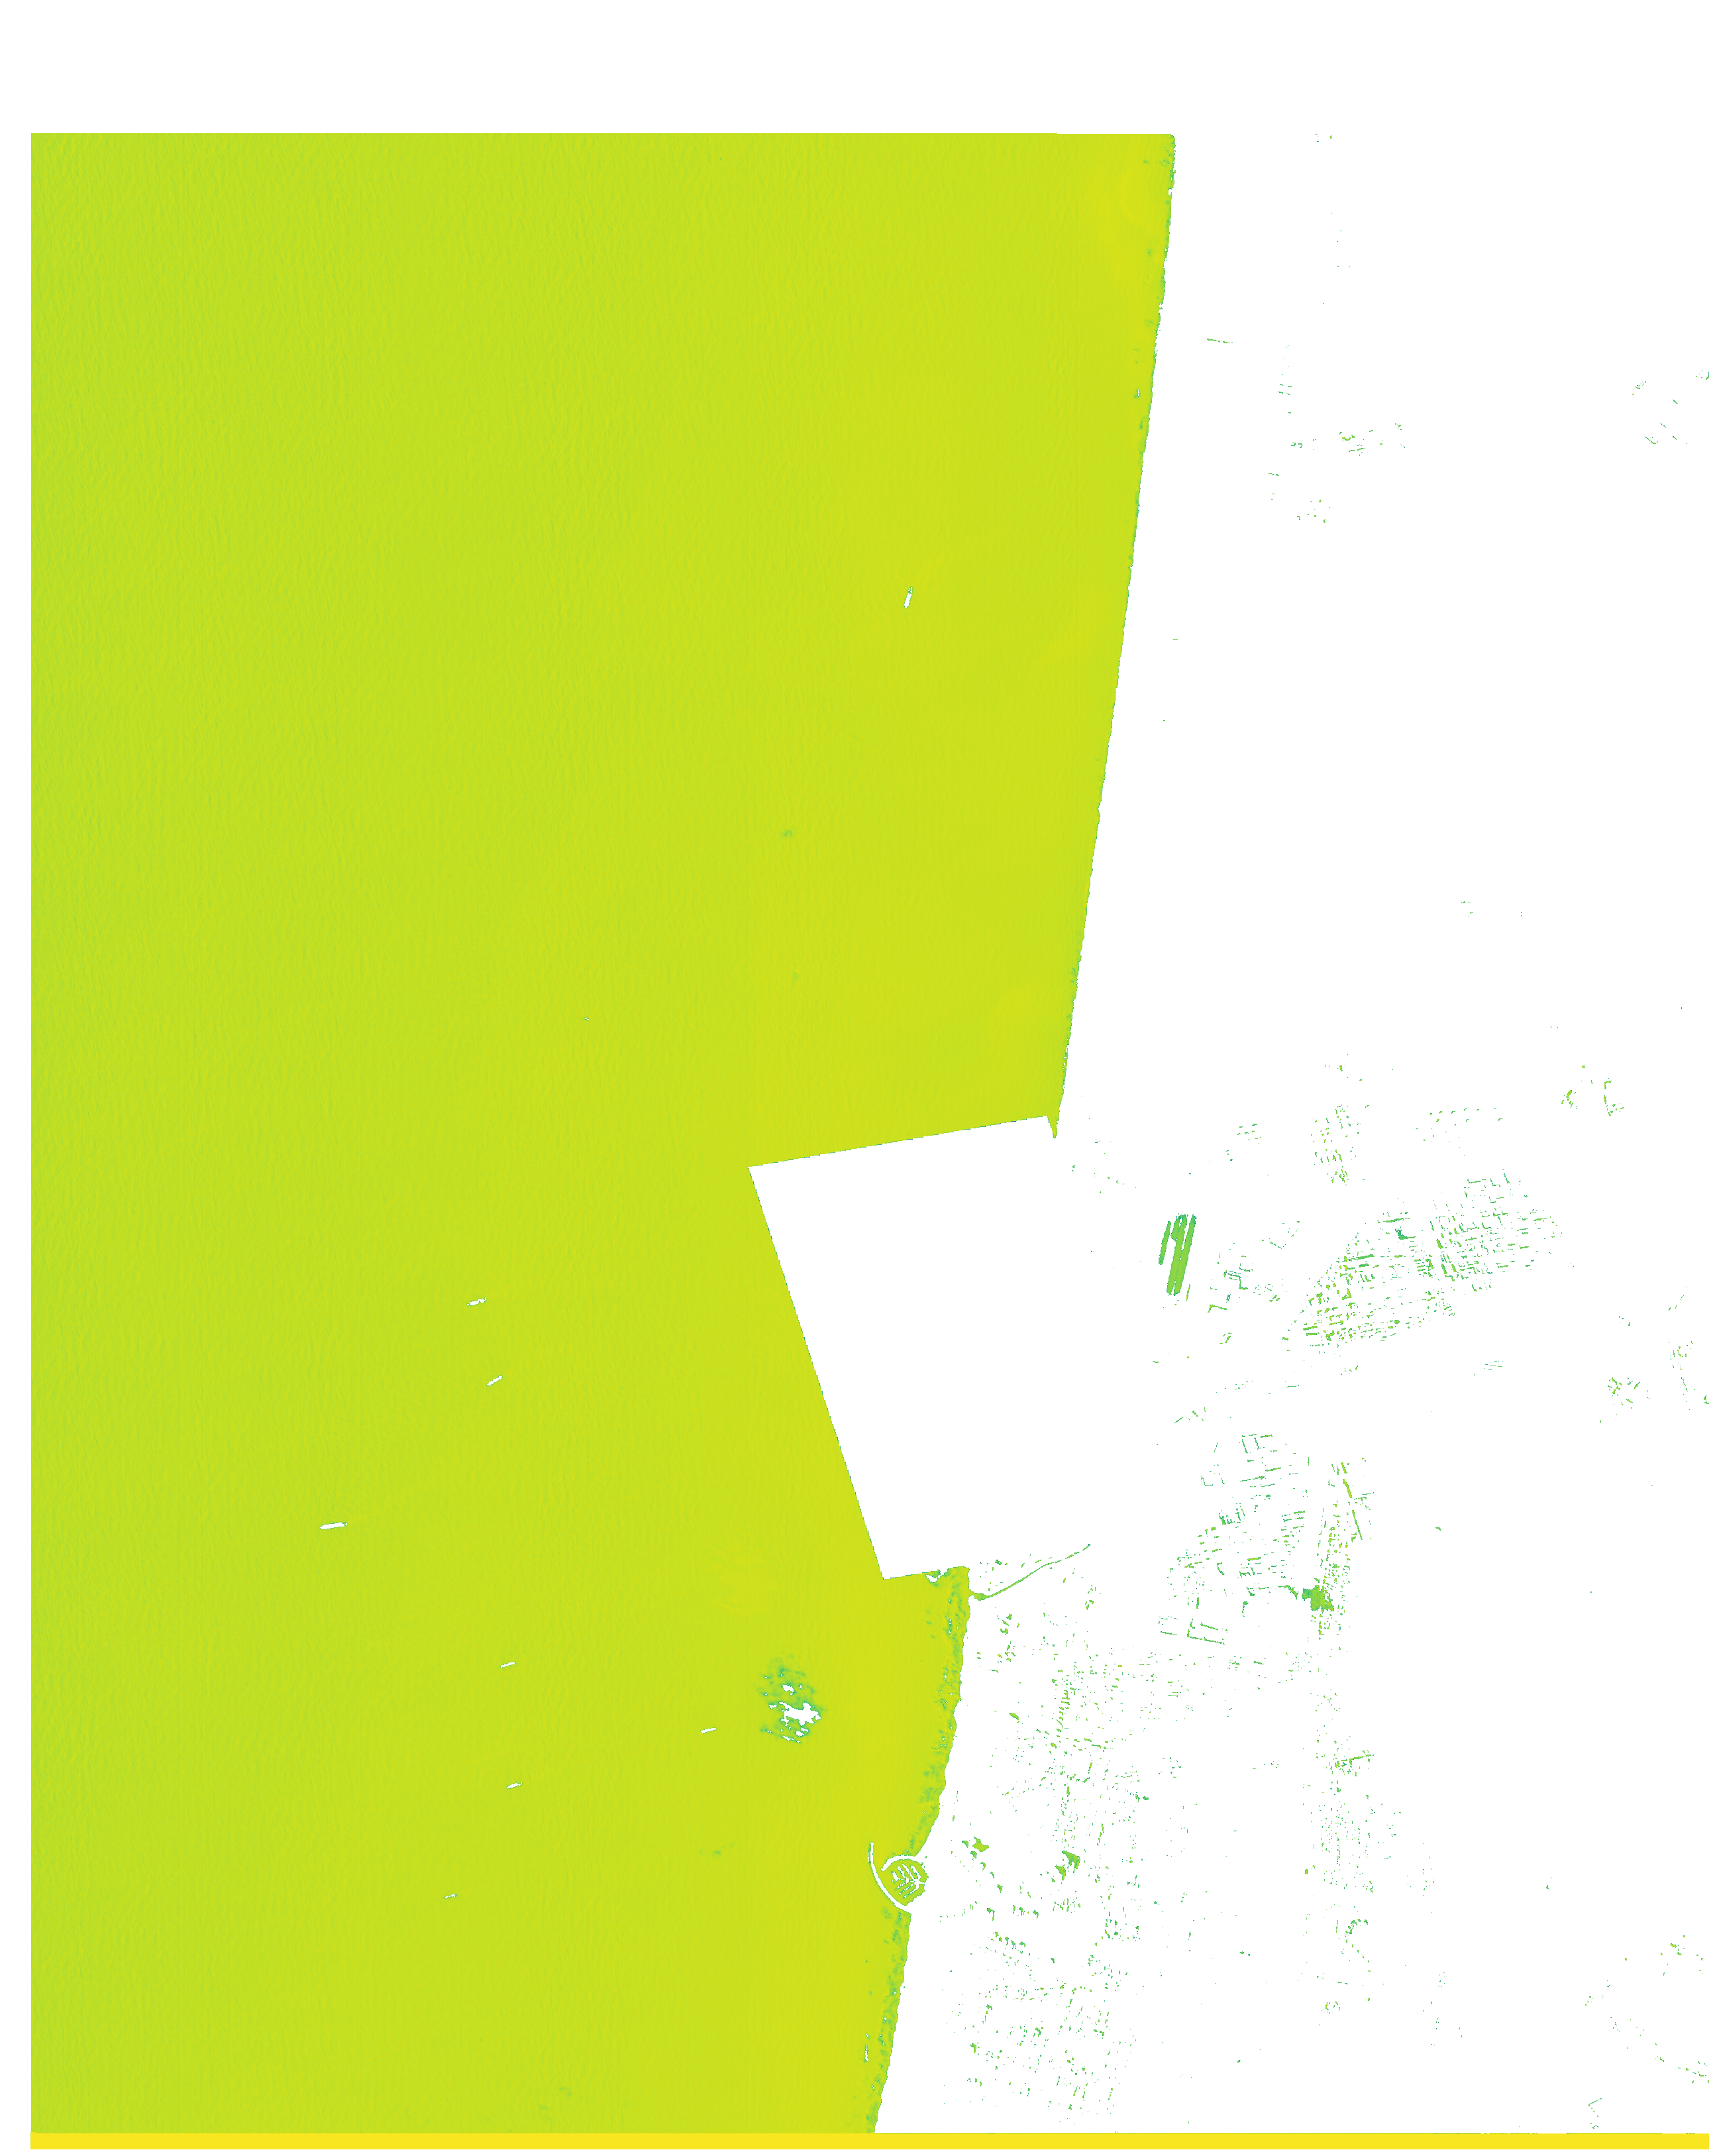

In [64]:
from matplotlib import colors
print('Loading file: ', path)
load = loader(results={'img_path': path})
img = load['img']

plt.figure(figsize=(42,42))
# image = img[:, :, 3]

NDWI =  calculate_ndwi(img)
image = NDWI

plt.imshow(image, cmap='viridis', norm=colors.LogNorm(vmin=image.mean()-3*image.std(), vmax=image.mean()+3*image.std()))
plt.axis(False)
plt.show()


In [66]:
image.shape

import numpy as np

image_with_channel = np.expand_dims(image, axis=2)
image_with_channel.shape


(2394, 1902)

In [ ]:
loader = LoadImageFromFile(to_float32=False, color_type='color', imdecode_backend='pillow', backend_args=None)

print('Loading file: ', path)
load = loader(results={'img_path': path})
img = load['img']



plt.figure(dpi=220)
plt.imshow(img[:,:,::-1])
plt.show()


In [ ]:
# show figure with gt_boxes:
draw_bounding_boxes(norm(img[:,:,::-1]), gt_boxes=gt_boxes, backend_args={'figsize': (12, 12)})

In [ ]:
img.shape

In [62]:
def compute_statistics(imgs, file_names, imgs_full_path, loader):
    
    for i in range(len(imgs)):
        path = find_full_path(file_names[i], imgs_full_path)
        load = loader(results={'img_path': path})
        img = load['img']
        
        num_channels = img.shape[2]
        means = { channel: [] for channel in range(num_channels) }
        deviations = { channel: [] for channel in range(num_channels) }
                    
        for channel in range(num_channels):
            channel_data = img[:, :, channel]
            m, d =  channel_data.mean(), channel_data.std()
            means[channel].append(m)
            deviations[channel].append(d)
            
    means = { channel: np.mean(means[channel]) for channel in means }
    deviations = { channel: np.mean(deviations[channel]) for channel in deviations }
            
    return means, deviations

# Calling the function:
means, deviations = compute_statistics(imgs, file_names, imgs_full_path, loader)



In [63]:
means = { channel: np.mean(means[channel]) for channel in means }
deviations = { channel: np.mean(deviations[channel]) for channel in deviations }

print(means)
print(deviations)

{0: 158.69588, 1: 124.42161, 2: 109.27108, 3: 105.380424, 4: 88.40926, 5: 98.93067, 6: 88.819916, 7: 94.20678, 8: 103.540764, 9: 111.64337, 10: 122.92817, 11: 79.31501}
{0: 34.95446, 1: 46.282494, 2: 56.252197, 3: 55.741932, 4: 64.54027, 5: 59.59095, 6: 69.65824, 7: 68.40028, 8: 77.930405, 9: 103.4634, 10: 105.30468, 11: 65.8369}


In [ ]:
for idx, filename in enumerate(file_names):
    path = find_full_path(file_names[idx], imgs_full_path)
    # copy image in the folder:
    shutil.copy(path, '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/S2ESA/imgs/')
